# OTG Meeting 13 Feb 2025

## Triple Decomposition
---

For a tracer, $\theta$, the triple decomposition ([Joyce, 1977](https://github.com/andrewfagerheim/argo-Vault/blob/main/Readings/Joyce%201977.pdf)) follows the form:

$$
\theta = \theta^m + \theta^e + \theta^t
$$

where:
- _m_ is the mean scale (vertical: >100m, horizontal: >100km)
- _e_ is the mesoscale (vertical: 10-100m, horizontal: 10-100km)
- _t_ is the microscale (vertical: <10m, horizontal: <10m). 

In my analysis, I've defined each scale in the following way:
- $\theta^m$: Tracer profile filtered at l=100m, $\overline{\theta}$
- $\theta^e$: Tracer profile with the mean scale subtracted, $\theta$ - $\overline{\theta}$
- $\theta^t$: We're assuming this scale does not show up in Argo float measurements

[Garrett (2001)](https://apps.dtic.mil/sti/pdfs/[ADP013572.pdf](https://apps.dtic.mil/sti/pdfs/ADP013572.pdf) described the pathways from mean scale to dissipation in two ways: 
1. Variance is produced by mesoscale eddy stirring, then passed to microscale turbulence.
2. Mean variance is directly acted on by microscale turbulence.

<img src="https://github.com/user-attachments/assets/ebf43d99-d245-413d-8129-399c25db3ced" alt="Triple Decomposition Equation" width="400">

## Tracer variance equations w/ triple decomposition:
---

[Ferrari & Polzin (2005)](https://github.com/andrewfagerheim/argo-Vault/blob/main/Readings/Ferrari%202005.pdf) wrote the tracer variance equations using the triple decomposition expansion. I'm going to be incredibly brave and type them out in latex.

$$
0 = < u_e \theta_e > \cdot \nabla \theta_m - < \widetilde{u_t \theta_t} \cdot \nabla \theta_e >
$$

$$
-\frac{1}{2} < \chi > = < u_t \theta_t > \cdot \nabla \theta_m + <\widetilde{u_t \theta_t} \cdot \nabla \theta_e >
$$

$$
-\frac{1}{2} < \chi > = < u_t \theta_t > \cdot \nabla \theta_m + < u_e \theta_e > \cdot \nabla_n \theta_m
$$

Ferrari & Polzin (2005) uses the flux gradient relationship (which assumes isopycnals are nearly horizontal) to parametrize each term. Below I've listed the term first as it appears in the equations above, and then with the parametrization that can be calculated using Argo data.


$$
[1] < u_e \theta_e > \cdot \nabla_n \theta_m \approx -K_e (\nabla_n \theta_m)^2
$$

$$
[2] < \widetilde{u_t \theta_t}  \cdot \nabla \theta_e > \approx -K_{\rho} (\widetilde{\partial z \theta_e})^2
$$

$$
[3] <u_t \theta_t > \cdot \nabla \theta_m \approx -K_{\rho} (\partial z \theta_m)^2
$$

$$
[4] \chi
$$

where $K_e$ is mesoscale effective diffusivity and $K_{\rho}$ is diapycnal turbulent diffusivity. 

This raises a _**MAJOR CAVVEAT**_ of my current results: I've reached out to someone asking for their Argo-derived isopycnic diffusivity estimates but haven't heard back yet. So, I'm using a constant of $K_{\rho} = 10e-5$ in my notebooks currently. This means that what I'm currently describing as "variance" is currently _only_ impacted by the vertical derivative of a tracer. 

Notebook Terminology
-
In my notebooks I use terms like "mesoscale variance" or "mesoscale fraction," so I will define what I mean here:
- "Mesoscale Variance/Pathway:" term (2) above
- "Microscale Variance/Pathway:" term (3) above
- "Total Variance:" term (2) + term (3)
- "Mesoscale Variance Ratio:" term (2) / (term (2) + term (3))
- "Mesoscale Variance Ratio:" term (3) / (term (2) + term (3))

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
from flox.xarray import xarray_reduce
import os

In [3]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [4]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/atl_basin.nc', chunks={'N_PROF':1000})

In [5]:
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))
ds

<xarray.Dataset> Size: 7GB
Dimensions:            (N_PROF: 135902, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW         (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    MLD                (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    month_frac         (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    year_frac          (N_PROF) float64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 1MB 0 1 2 3 ... 135899 135900 135901
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 544kB dask.array<chunksize=(1000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 544kB dask.array<chunksize=(1000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 544MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 1GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/01/17
    Fetched_constraints:  [x=5.00/10.00; y=-50.00/-45.00; z=0.0/2000.0]
    Fetched_uri:          
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [8]:
x='LATITUDE'
y='PRES_INTERPOLATED'
sample_max = 2.5
K_rho = 10**(-5)

In [7]:
ds= ds.sortby(x).persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

In [9]:
lfilt = 100

ct_b = ds.CT
sa_b = ds.SA

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m

In [11]:
ct_2 = K_rho*ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)
sa_2 = K_rho*ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)

ct_3 = K_rho*(ct_m.differentiate(coord='PRES_INTERPOLATED'))**2
sa_3 = K_rho*(sa_m.differentiate(coord='PRES_INTERPOLATED'))**2

In [12]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

In [13]:
deg = 3
lon_bins = np.arange(-75,25,deg)
lat_bins = np.arange(-75,85,deg)

In [14]:
count = xarray_reduce(
    ds.CT.notnull().astype(int),
    'LONGITUDE',
    'LATITUDE',
    func='sum',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [15]:
ds_ct_binned = xarray_reduce(
    ds.CT,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [16]:
ds_sa_binned = xarray_reduce(
    ds.SA,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [17]:
ds_sig_binned = xarray_reduce(
    ds.SIG0,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [18]:
ct_2_binned = xarray_reduce(
    ct_2,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [19]:
ct_3_binned = xarray_reduce(
    ct_3,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [20]:
 ct_2rat_binned = xarray_reduce(
    ct_2rat,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [21]:
sa_2_binned = xarray_reduce(
    sa_2,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [22]:
sa_3_binned = xarray_reduce(
    sa_3,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [23]:
sa_2rat_binned = xarray_reduce(
    sa_2rat,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)

In [27]:
count_min = 50
mask = count < count_min
masked_count = count.where(mask)

In [28]:
ct_start = 0
ct_end   = 16
ct_norm  = colors.Normalize(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.thermal

In [29]:
sa_start = 34.5
sa_end   = 36.5
sa_norm  = colors.Normalize(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.haline

In [30]:
ctvar_start = 10**-12
ctvar_end   = 10**-8
ctvar_norm  = colors.LogNorm(vmin=ctvar_start, vmax=ctvar_end)
var_cmap  = cmo.matter_r

In [31]:
savar_start = 10**-14
savar_end   = 10**-9
savar_norm  = colors.LogNorm(vmin=savar_start, vmax=savar_end)

In [66]:
rat_cmap = cmo.dense

In [75]:
plot_dict = {
    'CT': {'norm': ct_norm, 'cmap': ct_cmap, 'title': 'Conservative Temperature'},
    'SA': {'norm': sa_norm, 'cmap': sa_cmap, 'title': 'Absolute Salinity'},
    'CT_2': {'norm': ctvar_norm, 'cmap': var_cmap, 'title': 'Mesoscale Variance of Temperature'},
    'CT_3': {'norm': ctvar_norm, 'cmap': var_cmap, 'title': 'Microscale Variance of Temperature'},
    'SA_2': {'norm': savar_norm, 'cmap': var_cmap, 'title': 'Mesoscale Variance of Salinity'},
    'SA_3': {'norm': savar_norm, 'cmap': var_cmap, 'title': 'Microscale Variance of Salinity'},
    'CT_2RAT': {'norm': None, 'cmap': rat_cmap, 'title': 'Ratio of Mesoscale Temperature Variance'},
    'SA_2RAT': {'norm': None, 'cmap': rat_cmap, 'title': 'Ratio of Mesoscale Salinity Variance'}}

## Plots

In [37]:
depth = 500
lon   = 18
lat   = 36
levels = [26,27,27.4,27.7,27.8]

In [38]:
print('depth: {}m'.format(depth))
print('lon bin: {}'.format(ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()))
print('lat_bin: {}'.format(ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()))
print('SIG0 levels: {}'.format(levels))

depth: 500m
lon bin: (-21, -18]
lat_bin: (33, 36]
SIG0 levels: [26, 27, 27.4, 27.7, 27.8]


In [40]:
lon_left = ds_ct_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().left
lon_right = ds_ct_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).values.mean().right
lon_center = np.mean([lon_left, lon_right])

lat_left = ds_ct_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().left
lat_right = ds_ct_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).values.mean().right
lat_center = np.mean([lat_left, lat_right])

In [76]:
ds = ds_ct_binned
var = 'CT'

In [ ]:
plot_dict['CT']['title']

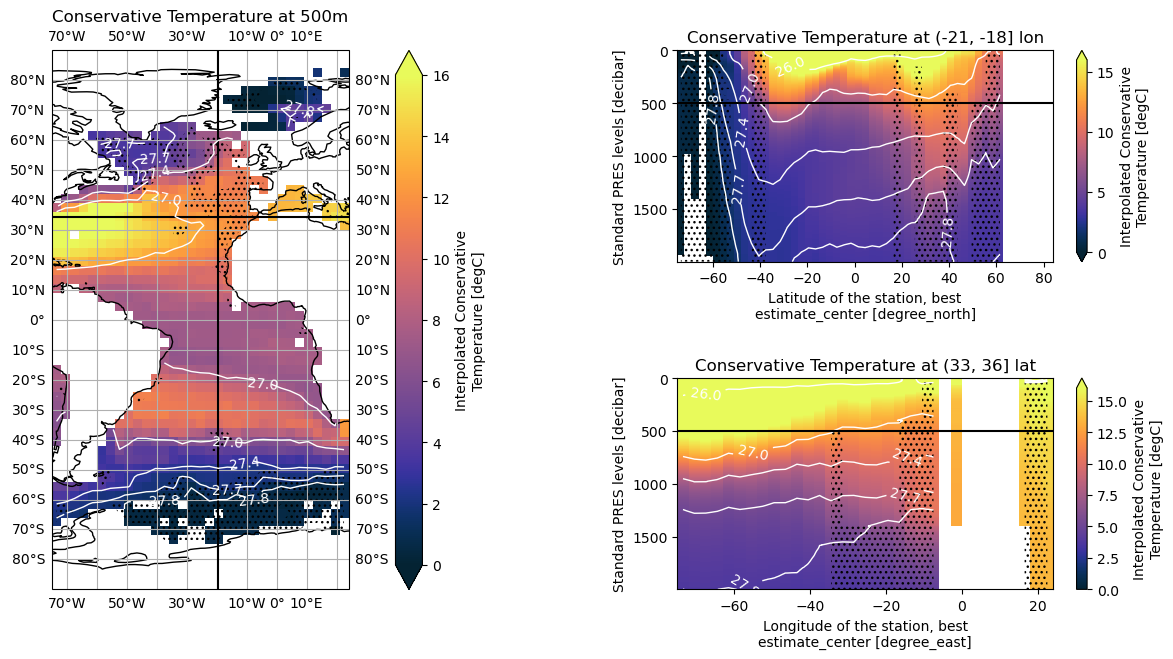

In [80]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ds.sel(PRES_INTERPOLATED=depth).plot(x='LONGITUDE_bins', y='LATITUDE_bins', ax=ax1, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.sel(PRES_INTERPOLATED=depth).plot.contourf(x='LONGITUDE_bins', y='LATITUDE_bins', levels=[0, 50], hatches=['...'], colors='none', ax=ax1, add_colorbar=False)
contour = ds_sig_binned.sel(PRES_INTERPOLATED=depth).plot.contour(x='LONGITUDE_bins', y='LATITUDE_bins', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'{plot_dict[var]['title']} at {depth}m')

ax2 = plt.subplot(gs[0, 1])
ds.isel(LONGITUDE_bins=lon).plot(x='LATITUDE_bins', y='PRES_INTERPOLATED', ax=ax2, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.isel(LONGITUDE_bins=lon).plot.contourf(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=[0, 50], hatches=['...'], colors='none', ax=ax2, add_colorbar=False)
contour = ds_sig_binned.isel(LONGITUDE_bins=lon).plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'{plot_dict[var]['title']} at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ds.isel(LATITUDE_bins=lat).plot(x='LONGITUDE_bins', y='PRES_INTERPOLATED', ax=ax4, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.isel(LATITUDE_bins=lat).plot.contourf(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=[0, 50], hatches=['...'], colors='none', ax=ax4, add_colorbar=False)
contour = ds_sig_binned.isel(LATITUDE_bins=lat).plot.contour(x='LONGITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'{plot_dict[var]['title']} at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()